In [27]:
import torch, os, gdown
from matplotlib import pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms as T
from PIL import Image

In [28]:
# root = "Moong_Lentil_Dataset"
# im_type = [".png", '.jpg', '.jpeg']

# im_paths = [im for im in sorted(glob(f"{root}/*[{i for i in im_type}]"))]
# for idx, paths in enumerate(im_paths):
#     s= get_classes(paths)
    

In [29]:
class CustomDataset(Dataset):
    def __init__(self, root,  im_type = [".png", '.jpg', '.jpeg'], transformations = None):
        super(). __init__()
        
        self.transformations = transformations
        self.im_paths = [im for im in sorted(glob(f"{root}/*[{i for i in im_type}]"))]
        self.labels = []
        self.class_name_dict = {}

        for idx, im_path in enumerate(self.im_paths):
            label = self.get_class_names(im_path)
            self.labels.append(label)
            self.uniq_class = [c for c in np.unique(list(self.labels))]
            self.class_name_dict = {keys: values for values , keys in enumerate(self.uniq_class)}
        
    # function for getting class_name from dataset
    def get_class_names(self, path):
        return os.path.basename(path).split("_")[-2]

    def __len__(self):
        return len(self.im_paths)



    def __getitem__(self, idx):
        ims = self.im_paths[idx]
        im = Image.open(ims).convert("RGB")

        gt = self.class_name_dict[self.get_class_names(ims)]
 

        if self.transformations is not None: im =self.transformations(im)

        return im, gt
transformer = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()])        
root = "Moong_Lentil_Dataset"
data = CustomDataset(root, transformations= transformer )
classes = data.class_name_dict
print(classes)
data[2]

{'skinned': 0, 'split': 1, 'whole': 2}


(tensor([[[0.7216, 0.7176, 0.7216,  ..., 0.5725, 0.5686, 0.5569],
          [0.7333, 0.7294, 0.7333,  ..., 0.5608, 0.5765, 0.5686],
          [0.7608, 0.7647, 0.7608,  ..., 0.5686, 0.5765, 0.5765],
          ...,
          [0.8510, 0.8510, 0.8549,  ..., 0.6549, 0.6510, 0.6549],
          [0.8431, 0.8392, 0.8510,  ..., 0.6667, 0.6510, 0.6549],
          [0.8510, 0.8275, 0.8275,  ..., 0.6510, 0.6510, 0.6549]],
 
         [[0.6941, 0.6863, 0.6941,  ..., 0.5490, 0.5490, 0.5294],
          [0.7059, 0.7020, 0.7098,  ..., 0.5412, 0.5569, 0.5451],
          [0.7294, 0.7333, 0.7294,  ..., 0.5529, 0.5569, 0.5490],
          ...,
          [0.8157, 0.8157, 0.8196,  ..., 0.6196, 0.6157, 0.6196],
          [0.8078, 0.8039, 0.8157,  ..., 0.6314, 0.6118, 0.6196],
          [0.8118, 0.7922, 0.7882,  ..., 0.6157, 0.6157, 0.6196]],
 
         [[0.6471, 0.6549, 0.6588,  ..., 0.5294, 0.5333, 0.5216],
          [0.6627, 0.6627, 0.6706,  ..., 0.5216, 0.5412, 0.5373],
          [0.6941, 0.6941, 0.6941,  ...,

In [30]:
# to devide tr, val, ts
tottal = len(data)
split = [0.8, 0.1, 0.1]
tr_len = int(tottal*split[0])
ts_len = int(tottal*split[1])
val_len= tottal-(tr_len+ts_len)
tr_ds, ts_ds, val_ds = random_split(dataset=data, lengths=[tr_len, ts_len, val_len ])

print(tr_len)
print(ts_len)
print(val_len)

238
29
31


In [31]:
#DataLoader
bs =8
tr_dl = DataLoader(dataset = tr_ds, batch_size = bs, shuffle =True, num_workers = 0)
ts_dl = DataLoader(dataset = ts_ds, batch_size = bs, shuffle =False, num_workers = 0)
val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle =False, num_workers = 0)
print(len(tr_dl))
print(len(ts_dl))
print(len(val_dl))



30
4
4


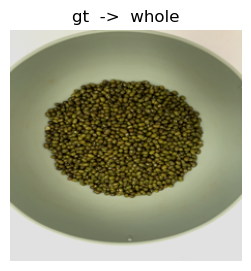

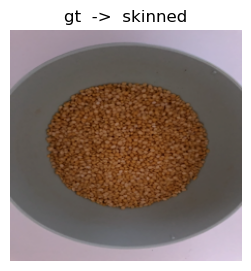

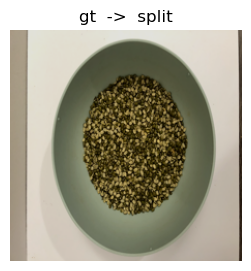

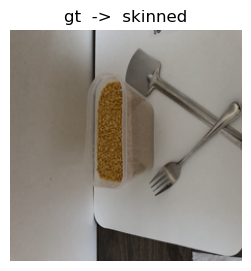

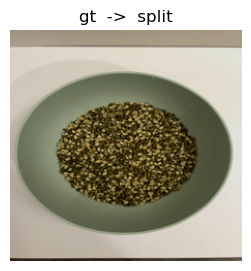

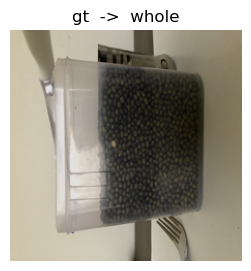

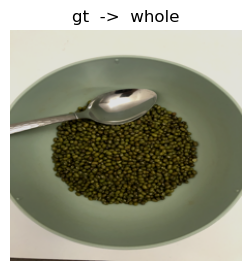

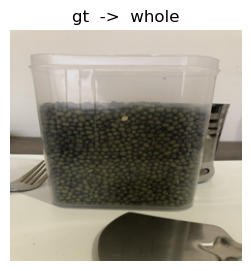

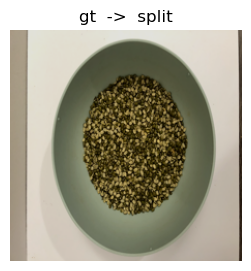

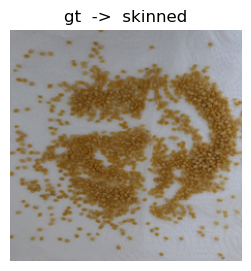

In [32]:
# Data Vizualization
import random

class_name = list(classes.keys())
data_num =10
index = [random.randint(0, len(data)-1) for _ in range(data_num)]
for idx, idxs in enumerate(index):
    im, gt = data[idxs]

    plt.figure(figsize=(6,3))
    plt.imshow((im*225).cpu().permute(2, 1, 0).numpy().astype("uint8"))
    plt.axis("off")
    plt.title(f"gt  ->  {class_name[gt]}")
    plt.show()

In [33]:
import timm
# model
model = timm.create_model(model_name='rexnet_150', pretrained=True, num_classes = len(classes))
device = "cuda" if torch.cuda.is_available() else 'cpu'
loss_fn = torch.nn.CrossEntropyLoss()
optimazer = torch.optim.SGD(params=model.parameters(), lr=0.001)
model.to(device)


RexNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
  )
  (features): Sequential(
    (0): LinearBottleneck(
      (conv_dw): ConvNormAct(
        (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
      (act_dw): ReLU6()
      (conv_pwl): ConvNormAct(
        (conv): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
    )
    (1): LinearBottlene

In [34]:
from tqdm import tqdm

def train(model, tr_dl, val_dl, epocs, device, opt, loss_fn, save_prefix, threshold):
    tr_acc_sc, tr_epoc_loss, val_acc_sc, val_epoc_loss = [],[],[],[]
   
    best_loss = np.inf
    print("Training is starting........")

    for epoc in range(epocs):
        print(f"{epoc+1} - epoch is starting.......")
        tr_sc, tr_loss = 0, 0
        tr_total = 0
        
        for ind, batch in enumerate(tqdm(tr_dl)):
            im, gt = batch
            im, gt = im.to(device), gt.to(device)
            
            # predict using the model
            pred = model(im)
            
            # calculate the loss using the loss function
            loss = loss_fn(pred, gt)
            
            # update the training loss
            tr_loss += loss.item()
            
            # get the indices of the maximum values in the predictions
            pred_classes = torch.argmax(pred, dim=1)
            
            # calculate training accuracy
            tr_sc += (pred_classes == gt).sum().item()
            tr_total += im.shape[0]
            
            # perform optimization steps
            opt.zero_grad()
            loss.backward()
            opt.step()
        tr_sc /= tr_total
        tr_loss/=len(tr_dl)

        tr_acc_sc.append(tr_sc)
        tr_epoc_loss.append(tr_loss)
        model.eval()
        with torch.no_grad():
            val_sc, val_loss, val_total = 0,0,0
            for inx, batch in enumerate(tqdm(val_dl)):
                im, gt = batch
                im, gt = im.to(device), gt.to(device)
                val_total+=im.shape[0]
                 # predict using the model
                pred = model(im)

                 # Calculate the loss using loss function
                
                loss = loss_fn(pred, gt)
                val_loss+=loss.item()
                
                # get the indices of the maximum values in the predictions
                pred_class = torch.argmax(pred, dim=1)
                val_sc+= (pred_class==gt).sum().item()
                
            val_sc /=val_total
            val_loss/= len(val_dl)
            
            val_acc_sc.append(val_sc)
            val_epoc_loss.append(val_loss)
            
            print(f"{epoc+1} - epoc Train process is fineshed\n")
            print(f"{epoc+1} - epoc Train Accurancy score     - > {tr_sc:.3f}")
            print(f"{epoc+1} - epoc Train loss score          - > {tr_loss:.3f}\n")
            
            print(f"{epoc+1} - epoc Validation process is fineshed\n")
            print(f"{epoc+1} - epoc Validation Accurancy score - > {val_sc:.3f}")
            print(f"{epoc+1} - epoc Valisation epoc loss score - > {val_loss:.3f}")
            
            if val_loss< (best_loss + threshold):
                val_loss = best_loss
                os.makedirs("1_best_model", exist_ok = True)
                torch.save(model, f"1_best_model/{save_prefix}_best_model.pht")
    
    return{"tr_acc_cs": tr_acc_sc, "tr_apoc_loss": tr_epoc_loss, "val_acc_sc": val_acc_sc, "val_apoc_loss": val_epoc_loss}
        
# Call the train function with the required arguments
result = train(model = model.to(device), tr_dl =tr_dl, val_dl = val_dl, epocs =10, device =device, opt = optimazer, loss_fn = loss_fn, save_prefix = "Moong", threshold = 0.001)


Training is starting........
1 - epoch is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


1 - epoc Train process is fineshed

1 - epoc Train Accurancy score     - > 0.433
1 - epoc Train loss score          - > 2.378

1 - epoc Validation process is fineshed

1 - epoc Validation Accurancy score - > 0.742
1 - epoc Valisation epoc loss score - > 0.936
2 - epoch is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 30.30it/s]


2 - epoc Train process is fineshed

2 - epoc Train Accurancy score     - > 0.487
2 - epoc Train loss score          - > 1.773

2 - epoc Validation process is fineshed

2 - epoc Validation Accurancy score - > 0.516
2 - epoc Valisation epoc loss score - > 1.039
3 - epoch is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 33.89it/s]


3 - epoc Train process is fineshed

3 - epoc Train Accurancy score     - > 0.597
3 - epoc Train loss score          - > 0.900

3 - epoc Validation process is fineshed

3 - epoc Validation Accurancy score - > 0.677
3 - epoc Valisation epoc loss score - > 0.690
4 - epoch is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 37.73it/s]


4 - epoc Train process is fineshed

4 - epoc Train Accurancy score     - > 0.929
4 - epoc Train loss score          - > 0.257

4 - epoc Validation process is fineshed

4 - epoc Validation Accurancy score - > 0.903
4 - epoc Valisation epoc loss score - > 0.296
5 - epoch is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 30.53it/s]


5 - epoc Train process is fineshed

5 - epoc Train Accurancy score     - > 0.987
5 - epoc Train loss score          - > 0.093

5 - epoc Validation process is fineshed

5 - epoc Validation Accurancy score - > 0.903
5 - epoc Valisation epoc loss score - > 0.203
6 - epoch is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 35.39it/s]


6 - epoc Train process is fineshed

6 - epoc Train Accurancy score     - > 1.000
6 - epoc Train loss score          - > 0.021

6 - epoc Validation process is fineshed

6 - epoc Validation Accurancy score - > 0.968
6 - epoc Valisation epoc loss score - > 0.147
7 - epoch is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 36.03it/s]


7 - epoc Train process is fineshed

7 - epoc Train Accurancy score     - > 1.000
7 - epoc Train loss score          - > 0.012

7 - epoc Validation process is fineshed

7 - epoc Validation Accurancy score - > 0.968
7 - epoc Valisation epoc loss score - > 0.126
8 - epoch is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 37.16it/s]


8 - epoc Train process is fineshed

8 - epoc Train Accurancy score     - > 1.000
8 - epoc Train loss score          - > 0.007

8 - epoc Validation process is fineshed

8 - epoc Validation Accurancy score - > 0.935
8 - epoc Valisation epoc loss score - > 0.113
9 - epoch is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 35.08it/s]


9 - epoc Train process is fineshed

9 - epoc Train Accurancy score     - > 1.000
9 - epoc Train loss score          - > 0.005

9 - epoc Validation process is fineshed

9 - epoc Validation Accurancy score - > 0.935
9 - epoc Valisation epoc loss score - > 0.102
10 - epoch is starting.......


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 31.99it/s]


10 - epoc Train process is fineshed

10 - epoc Train Accurancy score     - > 1.000
10 - epoc Train loss score          - > 0.004

10 - epoc Validation process is fineshed

10 - epoc Validation Accurancy score - > 0.935
10 - epoc Valisation epoc loss score - > 0.099


`Graphical representation`

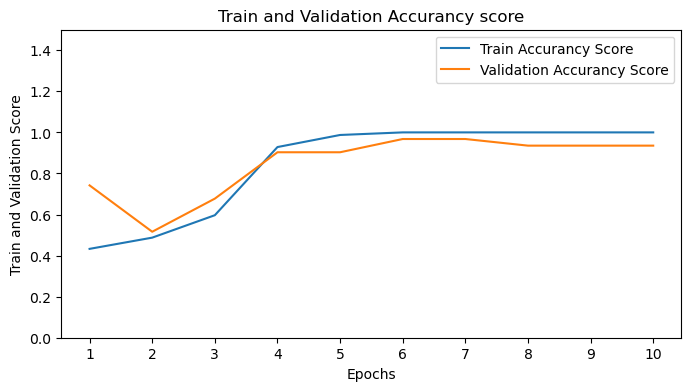

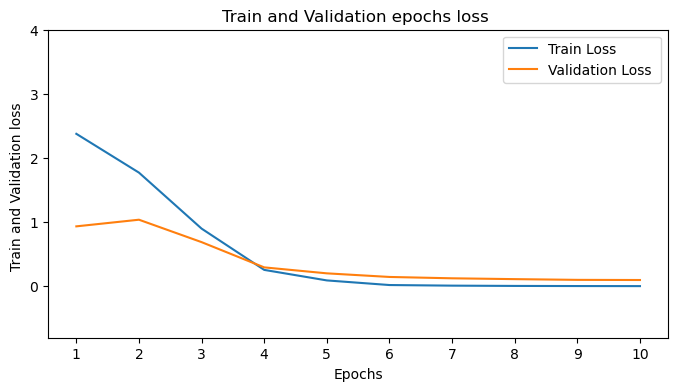

In [40]:
import random
class graphic():
    def __init__(self, res):
        

        plt.figure(figsize=(8, 4))
        plt.plot(res["tr_acc_cs"], label = "Train Accurancy Score")
        plt.plot(res["val_acc_sc"], label = "Validation Accurancy Score")
        plt.title("Train and Validation Accurancy score")
        plt.xlabel("Epochs")
        plt.xticks(np.arange(len(res['val_acc_sc'])), [ i for i in range(1, len(res['val_acc_sc'])+1)])
        plt.ylabel("Train and Validation Score")
        plt.ylim(0, 1.5)
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(8, 4))
        plt.plot(res["tr_apoc_loss"], label = "Train Loss ")
        plt.plot(res["val_apoc_loss"], label = "Validation Loss ")
        plt.title("Train and Validation epochs loss ")
        plt.xlabel("Epochs")
        plt.xticks(np.arange(len(res['val_apoc_loss'])), [ i for i in range(1, len(res['val_apoc_loss'])+1)])
        plt.ylabel("Train and Validation loss ")
        plt.ylim(-0.8, 4)
        plt.legend()
        plt.show()

graphic(result)

`Inference`   

In [ ]:
# def inference(data, model, device, number_of_im, class_name = None):
#     images, predicts = [],[]
#     for idx, batch in enumerate(data):
#         if idx ==number_of_im: break
#         im = batch
#         # im, gt = im.to(device), gt.to(device)
#         images.append(im)
#         pred = torch.argmax(model(im[0].unsqueeze(dim=0).to(device)), dim=1).item()
#         predicts.append(pred)

#     plt.figure(figsize=(6,3))
    
#     idxs = [random.randint(0, len(images)-1) for _ in range(number_of_im)]
#     for idx, index in enumerate(idxs):
#         im = images[index]
#         plt.imshow((im[0].cpu()*255).permute(2, 1, 0).numpy().astype("uint8"))
#         plt.axis("off")
#         plt.title(f" Pred   - > {class_name[predicts[index]]}")
#         plt.show()
# model = torch.load("1_best_model/Moong_best_model.pht")   
# inference(data = ts_ds, model=model.to(device), device = device, number_of_im = 10, class_name=list(classes.keys()))

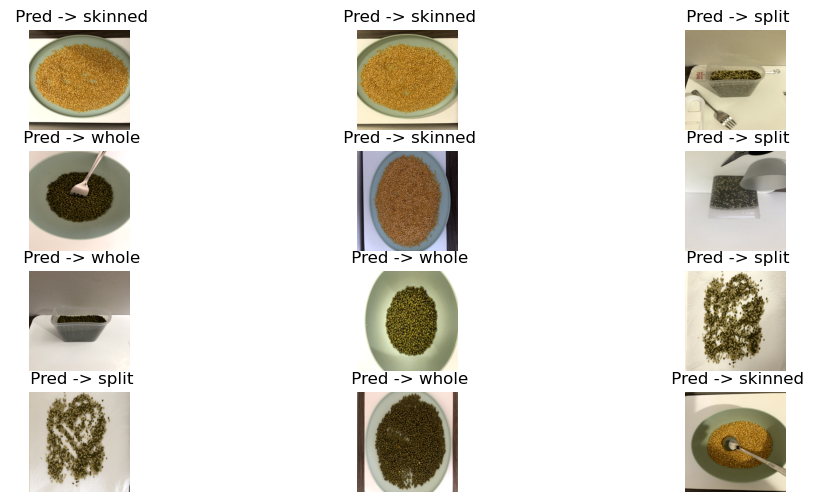

In [41]:
def inference(data, model, device, number_of_im, class_name=None, images_per_row=3):
    images, predicts = [], []
    
    for idx, batch in enumerate(data):
        if idx == number_of_im:
            break
        im = batch
        images.append(im)
        pred = torch.argmax(model(im[0].unsqueeze(dim=0).to(device)), dim=1).item()
        predicts.append(pred)

    plt.figure(figsize=(12, 6))
    
    for row in range(0, number_of_im, images_per_row):
        for col in range(images_per_row):
            index = row + col
            if index < number_of_im:
                im = images[index]
                plt.subplot(number_of_im // images_per_row, images_per_row, index + 1)
                plt.imshow((im[0].cpu() * 255).permute(2, 1, 0).numpy().astype("uint8"))
                plt.axis("off")
                plt.title(f" Pred -> {class_name[predicts[index]]}")

    plt.show()

model = torch.load("1_best_model/Moong_best_model.pht")   
inference(data=ts_ds, model=model.to(device), device=device, number_of_im=12, class_name=list(classes.keys()), images_per_row=3)


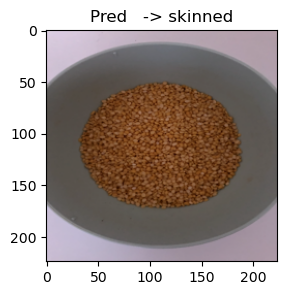

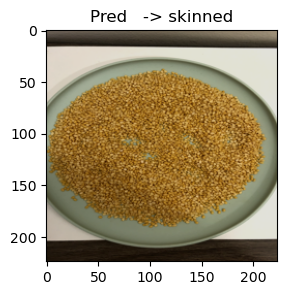

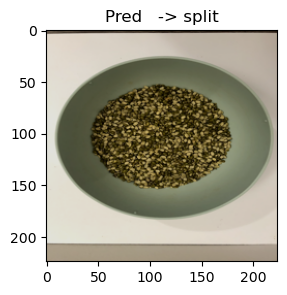

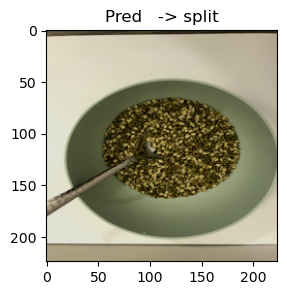

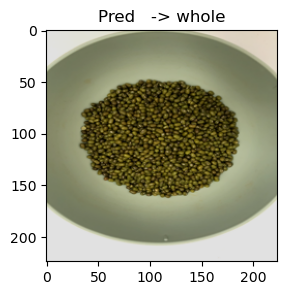

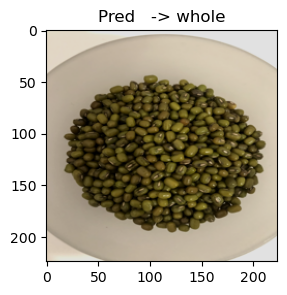

In [42]:
def process_images_predict(model, device, root, file_type =['.jpg', '.png', '.jpeg'] ):
    images, predicts = [],[]
    transformations = T.Compose([T.Resize((224, 224)),
                                T.ToTensor()])
    im_path = glob(f"{root}/*[{ i for i in file_type}]")
    for idx, path in enumerate(im_path):
        im = Image.open(path).convert("RGB")
        im_tersor = transformations(im)
        images.append(im_tersor)
        
        pred = torch.argmax(model(im_tersor.unsqueeze(dim=0).to(device)), dim=1).item()
        predicts.append(pred)

        plt.figure(figsize=(6, 3))
        plt.imshow((im_tersor*225).cpu().permute(2,1,0).numpy().astype("uint8"))
        plt.title(f"Pred   -> {list(classes.keys())[pred]}")
        plt.show()
root = "rasm"
process_images_predict(model=model.to(device), device=device, root=root)